# Analysis of available data for redshift correction

redshift correction is the prediction of `hostgal_specz` based on the less precise `hostgal_photoz`, its error, and other features available in the metadata.

Indeed, the precise redshift is rarely available in the test set, while very present in the training set.
On some rows of the training set, we have no information on the redshift at all.

This notebook explores the scale and proportions of the missing and available data for the training of a potential correction model, and the improvements it could do.

In [1]:
import pandas as pd

train_metadata = pd.read_csv('../data/training_set_metadata.csv')
test_metadata = pd.read_csv('../data/test_set_metadata.csv')

## Available training data

We can use data both on the 'training_set' and the 'test_set' to train our model

In [2]:
def get_valid_rows_mask(df):
    """ Get the mask to get rows with all redshift measures (for training) """
    return ((df['hostgal_specz'] != 0) & (df['hostgal_specz'].notnull()) \
          & (df['hostgal_photoz'] != 0) & (df['hostgal_photoz'].notnull()) \
          & (df['hostgal_photoz_err'] != 0) & df['hostgal_photoz_err'].notnull() \
          & (df['mwebv'] != 0) & df['mwebv'].notnull()
          & (df['distmod'] != 0) & df['distmod'].notnull()
          & (df['ddf'].notnull()))

def get_valid_rows_count(df):
    """ Get the number of rows that have all redshift measures (for training) """
    return get_valid_rows_mask(df).sum()

In [3]:
train_valid = get_valid_rows_count(train_metadata)
train_total = len(train_metadata)
test_valid = get_valid_rows_count(test_metadata)
test_total = len(test_metadata)
print(f'Potential training examples in training_set: {train_valid} out of {train_total}')
print(f'Potential training examples in test_set: {test_valid} out of {test_total}')

total_valid = test_valid + train_valid
print(f'In total, {total_valid} training examples')

Potential training examples in training_set: 5523 out of 7848
Potential training examples in test_set: 120393 out of 3492890
In total, 125916 training examples


## Potentially fixable missing data

In [4]:
def get_semivalid_rows_count(df):
    """ Get the number of rows that have all features except hostgal_specz """
    return (((df['hostgal_specz'] == 0) | (df['hostgal_specz'].isnull())) \
          & (df['hostgal_photoz'] != 0) & (df['hostgal_photoz'].notnull()) \
          & (df['hostgal_photoz_err'] != 0) & df['hostgal_photoz_err'].notnull() \
          & (df['mwebv'] != 0) & df['mwebv'].notnull()
          & (df['distmod'] != 0) & df['distmod'].notnull()
          & (df['ddf'].notnull())).sum()

In [5]:
train_fix = get_semivalid_rows_count(train_metadata)
test_fix = get_semivalid_rows_count(test_metadata)
print(f'Potential fixable examples in training_set: {train_fix} out of {train_total}')
print(f'Potential fixable examples in test_set: {test_fix} out of {test_total}')

Potential fixable examples in training_set: 0 out of 7848
Potential fixable examples in test_set: 2981987 out of 3492890


## Other stats

In [6]:
test_rows = test_metadata[get_valid_rows_mask(test_metadata)]
diff = test_rows['hostgal_photoz'] - test_rows['hostgal_specz']
diff_mean = diff.abs().mean()
print(f'Mean absolute error in test set: {diff_mean}')

ratio_over = (diff.abs() > test_rows['hostgal_photoz_err']).mean()
print(f'Ratio of measures outside the error range in test set: {ratio_over * 100} %')

Mean absolute error in test set: 0.16337531085694348
Ratio of measures outside the error range in test set: 33.85163589245222 %


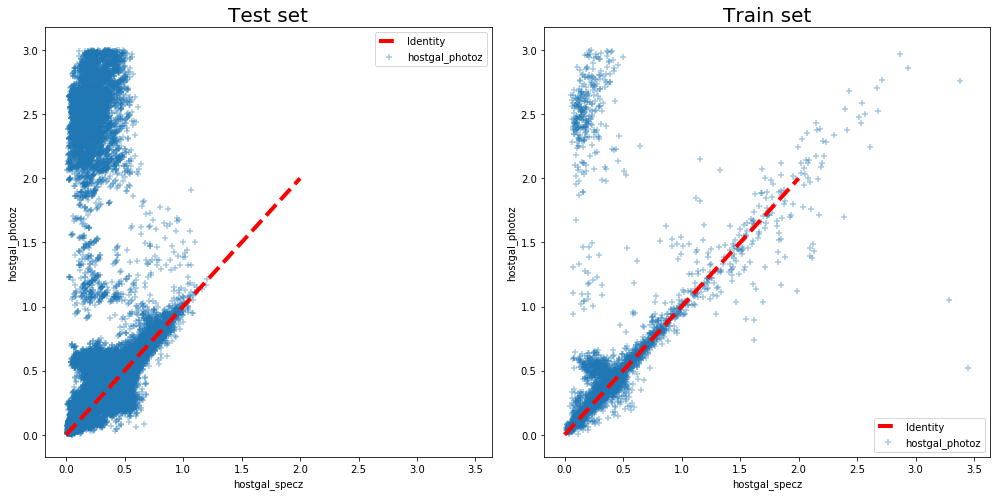

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

train_rows = train_metadata[get_valid_rows_mask(train_metadata)]


plt.figure(figsize=(14,7))

ax1 = plt.subplot(1, 2, 1)
plt.title('Test set', fontsize=20)
scat = plt.scatter(test_rows['hostgal_specz'], test_rows['hostgal_photoz'], marker='+', alpha=0.4)
ident = plt.plot([0, 2], [0, 2], '--r', linewidth=4, label='Identity')
plt.xlabel('hostgal_specz')
plt.ylabel('hostgal_photoz')
plt.legend()

ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.title('Train set', fontsize=20)
scat = plt.scatter(train_rows['hostgal_specz'], train_rows['hostgal_photoz'], marker='+', alpha=0.4)
ident = plt.plot([0, 2], [0, 2], '--r', linewidth=4, label='Identity')
plt.xlabel('hostgal_specz')
plt.ylabel('hostgal_photoz')
plt.legend()
plt.tight_layout()